In [185]:
import numpy as np
import math
import matplotlib.pyplot as plt
import copy

In [186]:
N = 50
x_all = [0.0]*N
y_all = [0.0]*N
box = 10  # Angstrom

k=0
for i in range (0,int(N/5)):
    for j in range(0,int(N/10)):
        x_all[k] = i*0.1*box + (np.random.rand()-0.5)*0.05*box
        if math.fmod(i,2) == 0.0:
#            y_all[k] = j*0.2*box + (np.random.rand()-0.5)*0.1
            y_all[k] = j*0.2*box + (np.random.rand()-0.5)*0.05*box
        else:
#            y_all[k] = j*0.2*box + 0.1 + (np.random.rand()-0.5)*0.1
            y_all[k] = j*0.2*box + 0.1*box + (np.random.rand()-0.5)*0.05*box
        k=k+1

x_start = [0.0]*N
y_start = [0.0]*N
for i in range (0,N):
    x_start[i] = x_all[i]
    y_start[i] = y_all[i]


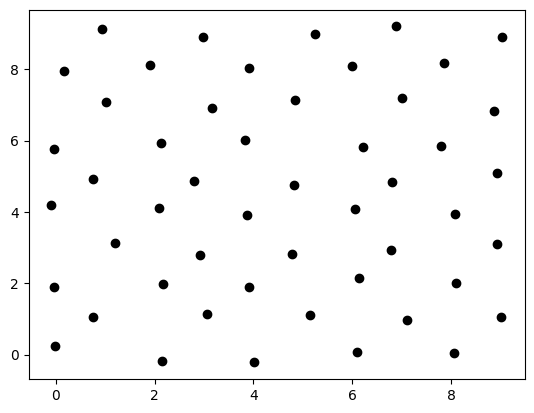

In [187]:
##  Visualize starting configuration  ##

for i in range(0,N):
    plt.scatter(x_start[i],y_start[i],c='k')
plt.show()


In [189]:
###  Use this for Simple Pairwise Potential  ##

def force(x_all,y_all):

    en = 0
    c = -1E-26/N  # Joules.Angstrom
    rc = 5  # Angstrom
    forces_x = [0.0]*N
    forces_y = [0.0]*N

    for i in range (0,N-1):
        for j in range (i+1,N):
            xr = x_all[i] - x_all[j]
            xr = xr - box*np.round(xr/box)
            yr = y_all[i] - y_all[j]
            yr = yr - box*np.round(yr/box)
            r = np.sqrt(xr*xr + yr*yr)
            if r <= rc:
                ff = (c/(r*r))*1E10  # converting to J/m
                forces_x[i] = forces_x[i] + ff*(xr/r)
                forces_x[j] = forces_x[j] - ff*(xr/r)
                forces_y[i] = forces_y[i] + ff*(yr/r)
                forces_y[j] = forces_y[j] - ff*(yr/r)
                en = en + c/r

    return(en,forces_x,forces_y)


In [190]:
###  Use this for Calculating Average Pairwise Distances  ##

def pair_distance(x_all,y_all):

    k = 0
    dist_avg = 0

    for i in range (0,N-1):
        for j in range (i+1,N):
            xr = x_all[i] - x_all[j]
            xr = xr - box*np.round(xr/box)
            yr = y_all[i] - y_all[j]
            yr = yr - box*np.round(yr/box)
            r = np.sqrt(xr*xr + yr*yr)
            dist_avg = dist_avg + r
            k = k+1

    dist_avg = dist_avg/k

    return(dist_avg)


In [191]:
##  Define MD Parameters  ##

Temp_start = 300  # Kelvin
m = 4.48E-26  # kg
dt = 1e-12  # seconds
kB = 1.380649E-23  # J/K


In [192]:
def init():

    x = [0.0]*N
    y = [0.0]*N
    xm = [0.0]*N
    ym = [0.0]*N

    vx = [0.0]*N
    vy = [0.0]*N
    sumvx = 0
    sumvy = 0
    sumv2 = 0

    k = 0
    for i in range (0,int(N/5)):
        for j in range(0,int(N/10)):
            x[k] = i*0.1*box + (np.random.rand()-0.5)*0.05*box
            if math.fmod(i,2) == 0.0:
                y[k] = j*0.2*box + (np.random.rand()-0.5)*0.05*box
            else:
                y[k] = j*0.2*box + 0.1*box + (np.random.rand()-0.5)*0.05*box
            k=k+1

    k = 0
    for i in range (0,int(N/5)):
        for j in range(0,int(N/10)):
            xm[k] = i*0.1*box + (np.random.rand()-0.5)*0.01*box
            if xm[k] >= box:
                xm[k] = xm[k] - int(xm[k])
            if xm[k] < 0.0:
                xm[k] = xm[k] - int(xm[k]) + box
            if math.fmod(i,2) == 0.0:
                ym[k] = j*0.2*box + (np.random.rand()-0.5)*0.01*box
            else:
                ym[k] = j*0.2*box + 0.1*box + (np.random.rand()-0.5)*0.01*box
            if ym[k] >= box:
                ym[k] = ym[k] - int(ym[k])
            if ym[k] < 0.0:
                ym[k] = ym[k] - int(ym[k]) + box
            k=k+1

    for i in range(0,N):
        xr = x[i] - xm[i]
        xr = xr - box*np.round(xr/box)
        vx[i] = (xr/dt)*1E-10  # m/s
        yr = y[i] - ym[i]
        yr = yr - box*np.round(yr/box)
        vy[i] = (yr/dt)*1E-10  # m/s


    for i in range(0,N):
        sumvx = sumvx + vx[i]
        sumvy = sumvy + vy[i]
        sumv2 = sumv2 + vx[i]*vx[i] + vy[i]*vy[i]

    sumvx = sumvx/N
    sumvy = sumvy/N
    sumv2 = sumv2/(2*N)

    fs = np.sqrt(2*kB*Temp_start/(m*sumv2))
    sumv2 = 0

    for i in range(0,N):
        vx[i] = (vx[i] - sumvx)*fs
        vy[i] = (vy[i] - sumvy)*fs
        sumv2 = sumv2 + vx[i]*vx[i] + vy[i]*vy[i]
        xm[i] = x[i] - vx[i]*dt
        ym[i] = y[i] - vy[i]*dt

    PE_start, fx, fy = force(x,y)
    KE_start = (0.5*sumv2*m)/(2*N)
    Temp = KE_start/kB

    return(x, y, vx, vy, xm, ym, PE_start, KE_start, Temp)


In [193]:
x, y, vx, vy, xm, ym, PE_start, KE_start, Temp = init()

In [194]:
Temp_start

300

In [195]:
Temp

299.4227143624126

In [242]:
def integrate(en, forces_x, forces_y, x, xm, y, ym):

    sumvx = 0
    sumvy = 0
    sumv2 = 0
    vx = [0.0]*N
    vy = [0.0]*N

    for i in range(0,N):

        xr = x[i] - xm[i]
        xr = xr - box*np.round(xr/box)
        xx = x[i] + xr + (dt*dt*forces_x[i]/m)*1E10
        if xx >= box:
          xx = xx - int(xx)
        if xx < 0.0:
          xx = xx - int(xx) + box

        yr = y[i] - ym[i]
        yr = yr - box*np.round(yr/box)
        yy = y[i] + yr + (dt*dt*forces_y[i]/m)*1E10
        if yy >= box:
          yy = yy - int(yy)
        if yy < 0.0:
          yy = yy - int(yy) + box

        xr = xx - xm[i]
        xr = xr - box*np.round(xr/box)
        vx[i] = (xr/(2*dt))*1E-10  # m/s
        yr = yy - ym[i]
        yr = yr - box*np.round(yr/box)
        vy[i] = (yr/(2*dt))*1E-10  # m/s
        sumvx = sumvx + vx[i]
        sumvy = sumvy + vy[i]
        sumv2 = sumv2 + vx[i]*vx[i] + vy[i]*vy[i]
        xm[i] = x[i]
        x[i] = xx
        ym[i] = y[i]
        y[i] = yy

    pot = en
    kin = (0.5*sumv2*m)/(2*N)
    etot = pot + kin
    Temp = kin/kB

#    etot = (en + 0.5*sumv2)/N

    return(Temp, pot, kin, etot, x, y, xm, ym)



In [243]:
def sample(x,y):

    return(pair_distance(x,y))


In [244]:
def md(tmax,dt,nsamp):

    x, y, vx, vy, xm, ym, pe_start, ke_start, temp_start = init()
    t = 0
    steps = round(tmax/dt)
    s = int(steps/nsamp)
    times = [0.0]*s
    PE = [0.0]*s
    KE = [0.0]*s
    TE = [0.0]*s
    Temp = [0.0]*s
    pair_dist = [0.0]*s
    k = 0
    x_start = copy.deepcopy(x)
    y_start = copy.deepcopy(y)

    for i in range(0,steps):
        en, fx, fy = force(x,y)
        T, pe, ke, te, x, y, xm, ym = integrate(en, fx, fy, x, xm, y, ym)
        t = t+dt
        if math.fmod(i, nsamp) == 0.0:
            k = int(i/nsamp)
            PE[k] = pe
            KE[k] = ke
            TE[k] = te
            Temp[k] = T
            times[k] = t
            pair_dist[k] = sample(x,y)
        # xm = copy.deepcopy(xm_new)
        # ym = copy.deepcopy(ym_new)
        # x = copy.deepcopy(x_new)
        # y = copy.deepcopy(y_new)

#     plt.plot(times[:], PE[:], c = 'r')
#     plt.plot(times[:], KE[:], c = 'b')
#     plt.plot(times[:], TE[:], c = 'grey')
#     plt.plot(times[:], Temp[:], c='k')
#     plt.plot(times[:], pair_dist[:], c = 'g')

    return(PE, KE, TE, Temp, x_start, y_start, x, y, pair_dist, times)



In [245]:
tmax = 5e-9 # seconds
dt = 1e-12  # seconds
nsamp = 10

PE, KE, TE, Temp, x_start, y_start, x_final, y_final, pair_dist, times = md(tmax,dt,nsamp)


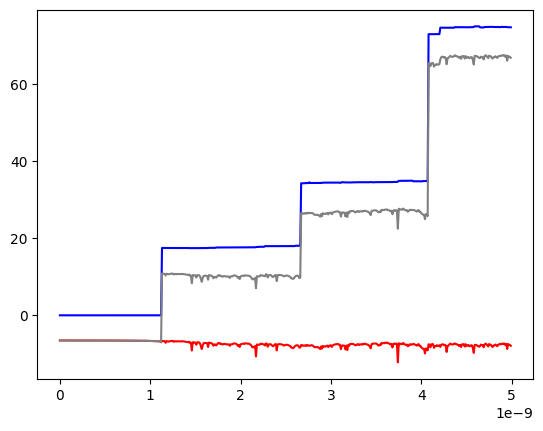

In [246]:
for i in range(0,len(times)):
    PE[i] = PE[i]*1e26
    KE[i] = KE[i]*1e26
    TE[i] = TE[i]*1e26

plt.plot(times[:], PE[:], c = 'r')
plt.plot(times[:], KE[:], c = 'b')
plt.plot(times[:], TE[:], c = 'grey')


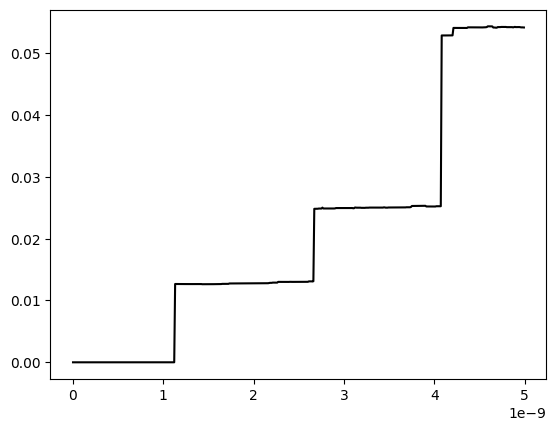

In [247]:
plt.plot(times[:], Temp[:], c='k')


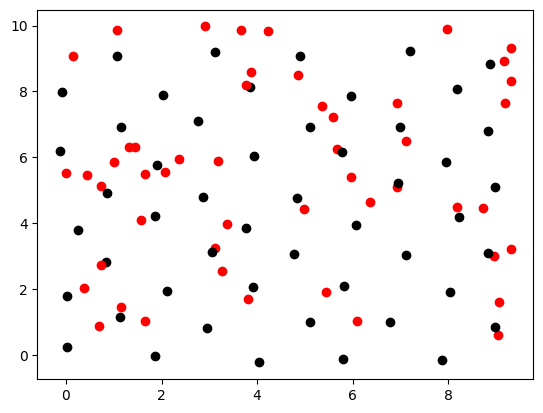

In [236]:
for i in range(0,N):
    plt.scatter(x_start[i],y_start[i],c='k')
    plt.scatter(x_final[i],y_final[i],c='r')
plt.show()


In [215]:
x_start[0:5]

[0.20518253930654454,
 0.11092208845611586,
 -0.0273186679710587,
 -0.009065891090853817,
 -0.24612746599982627]

In [216]:
x_final[0:5]

[0.30865276966631167,
 0.22905393375664265,
 0.08218761988088243,
 9.936227824781541,
 9.590234363787578]

In [ ]:
## Run this cell only for Anderson thermostat (to keep temp fixed) ##

def integrate(switch, en, forces_x, forces_y, x, y, vx, vy, temp):

    sumvx = 0
    sumvy = 0
    sumv2 = 0
    vx = [0.0]*N
    vy = [0.0]*N
    nu = 5
    Temp = 0


    if switch == 1:

        for i in range(0,N):

            xx = x[i] + vx[i]*dt + dt*dt*forces_x[i]/(2*m)
            if xx >= 1.0:
              xx = xx - int(xx)
            if xx < 0.0:
              xx = xx - int(xx) + 1
            x[i] = copy.deepcopy(xx)
            vx[i] = vx[i] + dt*forces_x[i]/(2*m)

            yy = y[i] + vy[i]*dt + dt*dt*forces_y[i]/(2*m)
            if yy >= 1.0:
              yy = yy - int(yy)
            if yy < 0.0:
              yy = yy - int(yy) + 1
            y[i] = copy.deepcopy(yy)
            vy[i] = vy[i] + dt*forces_y[i]/(2*m)


    elif switch == 2:

        tempa = 0

        for i in range(0,N):
            vx[i] = vx[i] + dt*forces_x[i]/(2*m)
            tempa = tempa + vx[i]*vx[i]
            vy[i] = vy[i] + dt*forces_y[i]/(2*m)
            tempa = tempa + vy[i]*vy[i]
        tempa = tempa/((3/m)*N)
        sigma = np.sqrt(temp)
        for i in range(0,N):
            if np.random.rand() < nu*dt:
                samples = np.random.normal(loc=0, scale=sigma, size=1000)
                vx[i] = samples[np.random.randint(0,1000)]
                vy[i] = samples[np.random.randint(0,1000)]

        Temp = copy.deepcopy(tempa)


    sumvx = sumvx + vx[i]
    sumvy = sumvy + vy[i]
    sumv2 = sumv2 + vx[i]*vx[i] + vy[i]*vy[i]

    pot = en
    kin = 0.5*sumv2*m
    etot = pot + kin

#    etot = (en + 0.5*sumv2)/N

    return(Temp, pot, kin, etot, x, y)



In [ ]:
## Example of Gaussian distribution ##

import numpy as np

sigma = 2.5  # Set the desired sigma value
samples = np.random.normal(loc=0, scale=sigma, size=1000)

# Print some of the samples
print(samples[:10])

plt.hist(samples, bins=50)
plt.show()

In [ ]:
def md_anderson(tmax,dt,nsamp,T):

    x, y, vx, vy, xm, ym, pe_start, ke_start = init()
    en, fx, fy = force(x,y)
    t = 0
    steps = round(tmax/dt)
    s = int(steps/nsamp)
    times = [0.0]*s
    PE = [0.0]*s
    KE = [0.0]*s
    TE = [0.0]*s
    Temp = [0.0]*s
    pair_dist = [0.0]*s

    x_new = x
    y_new = y
    k = 0

    for i in range(0,steps):
        T, pe, ke, te, x_new, y_new = integrate(1, en, fx, fy, x_new, y_new, vx, vy, T)
        en, fx, fy = force(x_new,y_new)
        T, pe, ke, te, x_new, y_new = integrate(2, en, fx, fy, x_new, y_new, vx, vy, T)
        t = t+dt
        if math.fmod(i, nsamp) == 0.0:
            k = int(i/nsamp)
            PE[k] = pe
            KE[k] = ke
            TE[k] = te
            Temp[k] = T
            times[k] = t
            pair_dist[k] = sample(x_new,y_new)

#    plt.plot(times[:], PE[:], c = 'r')
#    plt.plot(times[:], KE[:], c = 'b')
#    plt.plot(times[:], TE[:], c = 'grey')
    plt.plot(times[:], Temp[:], c='k')
#    plt.plot(times[:], pair_dist[:], c = 'g')

    return(PE, KE, TE, x_new, y_new, pair_dist)



In [ ]:
###  Use this for Lennard Jones Potential  ##
###  (https://en.wikipedia.org/wiki/Lennard-Jones_potential)

def force(x_all,y_all):

    en = 0
    forces_x = [0.0]*N
    forces_y = [0.0]*N
    rc = 0.2
    eps = 1e-42

    for i in range (0,N-1):
        for j in range (i+1,N):
            xr = x_all[i] - x_all[j]
            xr = xr - box*np.round(xr/box)
            yr = y_all[i] - y_all[j]
            yr = yr - box*np.round(yr/box)

            r2 = xr*xr + yr*yr

            if r2 <= rc*rc:
                r2i = 1/r2
                r6i = np.power(r2i,3)
                ff = 48*eps*r2i*r6i*(r6i-0.5)
                forces_x[i] = forces_x[i] + ff*xr
                forces_x[j] = forces_x[j] - ff*xr
                forces_y[i] = forces_y[i] + ff*yr
                forces_y[j] = forces_y[j] - ff*yr
                en = (en + 4*eps*r6i*(r6i-1))

    return(en,forces_x,forces_y)
